In [1]:
import numpy as np
import matplotlib.pyplot as plt

from QKDfunctions import *

from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.circuit import Parameter
from qiskit.extensions import IdGate
from qiskit.providers.aer.noise import NoiseModel, errors

from IPython.display import display, Math, Latex, clear_output

# E91 protocol (entanglement)
## Table of Contents:
* [Introduction & Theory](#intro)
* [Plain protocol](#protocol)
* [Working protocol with Eavesdropper](#eve)
* [Protocol on NV with Noise](#noise)


## Introduction & Theory <a class="anchor" id="intro"></a>

In the entanglement protocol someone (could be third party, could be Alice/Bob) prepares an entangled state $\mid00\rangle+\mid11\rangle = \mid++\rangle+\mid--\rangle$. This person then sends one photon to Alice and one to Bob. Alice and bob choose a random basis +/- or 0/1 and measure the photon. If they chose the same basis they got the same bit.

## Plain protocol <a class="anchor" id="protocol"></a>

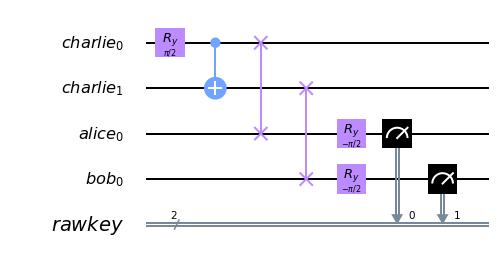

In [2]:
# Create the circuit
A = QuantumRegister(1, 'alice')
B = QuantumRegister(1, 'bob')
C = QuantumRegister(2, 'charlie')
rawkey = ClassicalRegister(2, 'raw key')

qc = QuantumCircuit(C, A, B, rawkey)

# Add the gates
qc.ry(np.pi/2, C[0])
qc.cx(C[0], C[1])

qc.swap(C[0], A[0])
qc.swap(C[1], B[0])
qc.ry(-np.pi/2, A[0])
qc.ry(-np.pi/2, B[0])
qc.measure(A[0], rawkey[0])
qc.measure(B[0], rawkey[1])

cplot=qc.draw(output='mpl')
display(cplot)

## Working protocol with Eavesdropper <a class="anchor" id="eve"></a>

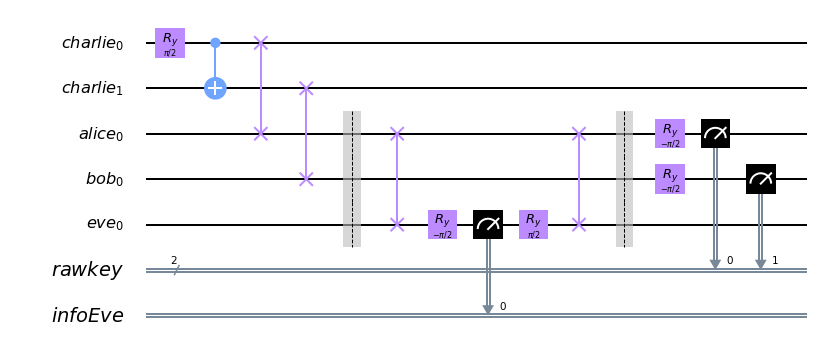

In [3]:
# Create the circuit
A = QuantumRegister(1, 'alice')
B = QuantumRegister(1, 'bob')
C = QuantumRegister(2, 'charlie')
E = QuantumRegister(1, 'eve')
rawkey = ClassicalRegister(2, 'raw key')
infoE = ClassicalRegister(1, 'infoEve')

qc = QuantumCircuit(C, A, B, E, rawkey, infoE)

# Add the gates
qc.ry(np.pi/2, C[0])
qc.cx(C[0], C[1])

qc.swap(C[0], A[0])
qc.swap(C[1], B[0])

# Eve drops
qc.barrier(A,B,E)
qc.swap(A[0], E[0])
qc.ry(-np.pi/2, E[0])
qc.measure(E[0], infoE[0])
qc.ry(np.pi/2, E[0])
qc.swap(A[0], E[0])
qc.barrier(A,B,E)

qc.ry(-np.pi/2, A[0])
qc.ry(-np.pi/2, B[0])
qc.measure(A[0], rawkey[0])
qc.measure(B[0], rawkey[1])

cplot=qc.draw(output='mpl')
display(cplot)

In [83]:
N = 100
chanceE = 0.5   # Chance Eve drops (1 = 100%)
print_table = True

# Create the precircuit (without A & B basis choice + measurements)
A = QuantumRegister(1, 'alice')
B = QuantumRegister(1, 'bob')
C = QuantumRegister(2, 'charlie')
E = QuantumRegister(1, 'eve')
rawkey = ClassicalRegister(2, 'rawkey')
infoE = ClassicalRegister(1, 'infoEve')

qc = QuantumCircuit(C, A, B, E, rawkey, infoE)

# Apply the gates
qc.ry(np.pi/2, C[0])
qc.cx(C[0], C[1])
qc.swap(C[0], A[0])
qc.swap(C[1], B[0])
qc.barrier(A,B,C,E)

backend = BasicAer.get_backend('statevector_simulator')
keyA = np.zeros(N, dtype=int)
keyB = np.zeros(N, dtype=int)
M = 0  # counter for key

basisA = np.random.randint(2, size=N)
basisB = np.random.randint(2, size=N)
basisE = np.random.choice([0,1,2], p=[0.5*chanceE, 0.5*chanceE, 1-chanceE], size=N)
dataA = np.zeros(N, dtype=int)
dataB = np.zeros(N, dtype=int)
dataE = np.zeros(N, dtype=int)

if print_table:
    print('result A B | result E ')
    print('------------------------')

for i in range(N):
    # Reset the E, A & B part of the circuit
    ABE_qc = QuantumCircuit(C, A, B, E, rawkey, infoE)
    
    # Eve does her thing
    if basisE[i] == 0:
        ABE_qc.swap(A[0], E[0])
        ABE_qc.measure(E[0], infoE[0])
        ABE_qc.swap(A[0], E[0])
        ABE_qc.barrier(A,B,C,E)
    elif basisE[i] == 1:
        ABE_qc.swap(A[0], E[0])
        ABE_qc.ry(-np.pi/2, E[0])
        ABE_qc.measure(E[0], infoE[0])
        ABE_qc.ry(np.pi/2, E[0])
        ABE_qc.swap(A[0], E[0])
        ABE_qc.barrier(A,B,C,E)
    
    # Randomly choose a basis for A & B
    if basisA[i] == 1: ABE_qc.ry(-np.pi/2, A[0])
    if basisB[i] == 1: ABE_qc.ry(-np.pi/2, B[0])
    ABE_qc.measure(A[0], rawkey[0])
    ABE_qc.measure(B[0], rawkey[1])   
        
    # Build the new total circuit
    circuit_total = qc.combine(ABE_qc)
    
    # Run the circuit
    job = execute(circuit_total, backend=backend, shots=1)
    output_state = job.result().get_statevector(circuit_total)
    
    result = job.result()
    counts = result.get_counts()

    # Save the results from the run
    k = list(counts.keys())[0]
    k = ' '.join(k)
    dataEAB = np.fromstring(k,sep=' ', dtype=int)
    dataE[i] = dataEAB[0]
    dataA[i] = dataEAB[1]
    dataB[i] = dataEAB[2]

    # Make the key
    if basisA[i] == basisB[i]: 
        keyA[M] = dataA[i]
        keyB[M] = dataB[i]
        M += 1
            
    bitA = give_bit(basisA[i], dataA[i])
    bitB = give_bit(basisB[i], dataB[i])
    bitE = give_bit(basisE[i], dataE[i])
    
    if print_table: 
        print('    {0} {1}    |    {2}   '.format(bitA, bitB, bitE))
    else:
        # Show progress 
        print('Currently at: {0}/{1}  :  {2}%'.format(i+1, N, int(float((i+1))*100/N)))
        clear_output(wait=True)
        
keyA = keyA[0:M]
keyB = keyB[0:M]
QBER = np.sum(keyA != keyB)
print('QBER: {0}%'.format(int(QBER/M*100)))

QBER: 18%


## Protocol on NV with Noise <a class="anchor" id="noise"></a>

QBER: 0.23024999999999998 +/- 0.011161877082283252


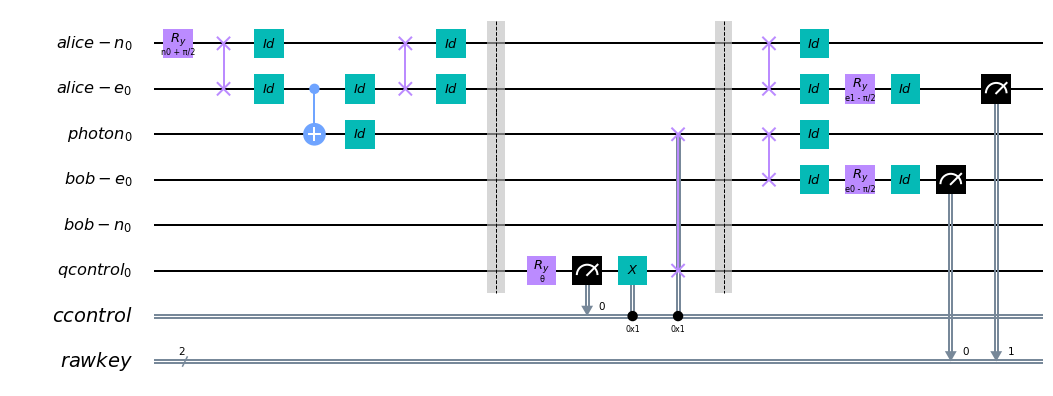

In [97]:
# Initialize variables 
N = 1000             # number of shots per pick
number_picks = 20    # Number of picks per set of sigmas
length = 0.05        # Length of photon fiber
att_length = 0.542   # in km
Fg = 1-0.98          # Depolarizing parameter for two qubit gates in quantum memories
Fprep = 1-0.99       # Dephasing parameter for the memory-photon state preparation
Fm = 1-0.95          # Depolarizing parameter for the measurement of the electron spin
noise_n = 0.142      # The 1-sigmas that will be used on carbon gates
noise_e = 0.142      # The 1-sigmas that will be used on electron gates

# Create the circuit
An = QuantumRegister(1, 'alice-n')
Ae = QuantumRegister(1, 'alice-e')
Bn = QuantumRegister(1, 'bob-n')
Be = QuantumRegister(1, 'bob-e')
p = QuantumRegister(1, 'photon')
control = QuantumRegister(1,'qcontrol')
init = ClassicalRegister(1,'ccontrol')
rawkey = ClassicalRegister(2, 'raw key')

qc = QuantumCircuit(An, Ae, p, Be, Bn, control, init, rawkey)

# Define parameters    !you need one for EACH gate!
pi_par = Parameter('π')     # Parameter to show pi nicely
noise_n0 = Parameter('n0')  # Parameter to control noise on carbon gates
noise_e0 = Parameter('e0')    # Parameter to control noise on electron gates
noise_e1 = Parameter('e1')
theta_par = Parameter('θ')  # Parameter to control relaxation noise of photon

# Alice sends entangled photon   
noisy_ry(pi_par/2, qc, An[0], noise=noise_n0)
send_photon(qc, An[0], Ae, Bn[0], Be, p, control, init, theta_par)
noisy_swap(qc, Ae, An, 'eswap')

# Alice and Bob measure in the +/- basis
noisy_ry(pi_par/-2, qc, Be, noise=noise_e0)
noisy_measure(qc, Be, rawkey[0])
noisy_ry(pi_par/-2, qc, Ae, noise=noise_e1)
noisy_measure(qc, Ae, rawkey[1])

# DONT Loop through the parameters (YET)
theta_val = 2*np.arccos(np.exp(-length/(2*att_length)))
noise_depo = Fg
noise_deph = Fprep
noise_meas = Fm

backend = Aer.get_backend('qasm_simulator')
qber_pick = np.zeros(number_picks)

for randpick in range(number_picks):
    # Choose a random noise for the carbon and electron gates
    n0 = np.random.normal(scale=noise_n)
    e0 = np.random.normal(scale=noise_e)
    e1 = np.random.normal(scale=noise_e)
    
    circuit = qc.bind_parameters({pi_par: np.pi, theta_par: theta_val, noise_n0: n0, noise_e0: e0, noise_e1: e1})

    # Build the noise model
    noisemodel = NoiseModel()
    depo = errors.depolarizing_error(noise_depo, 1)
    deph = errors.phase_damping_error(noise_deph, 1)
    depo_meas = errors.depolarizing_error(noise_meas, 1)
    noisemodel.add_all_qubit_quantum_error(depo,'Cswap')
    noisemodel.add_all_qubit_quantum_error(deph,'eswap')
    noisemodel.add_all_qubit_quantum_error(depo_meas,'meas')
    
    job = execute(circuit, backend=backend, shots=N, noise_model=noisemodel)
    result = job.result()
    counts = result.get_counts()

    try:
        qber_pick[randpick] += counts['01 0']/N
    except:
        pass    
    try:
        qber_pick[randpick] += counts['10 0']/N
    except:
        pass    
    try:
        qber_pick[randpick] += counts['01 1']/N
    except:
        pass    
    try:
        qber_pick[randpick] += counts['10 1']/N
    except:
        pass

    # Show progress 
    print('Currently at: {0}/{1}'.format(randpick, number_picks))
    clear_output(wait=True)
    
qber = np.mean(qber_pick)
qber_std = np.std(qber_pick)
print('QBER:', qber, '+/-', qber_std)
        
# Draw the circuit
display(qc.draw(output='mpl'))

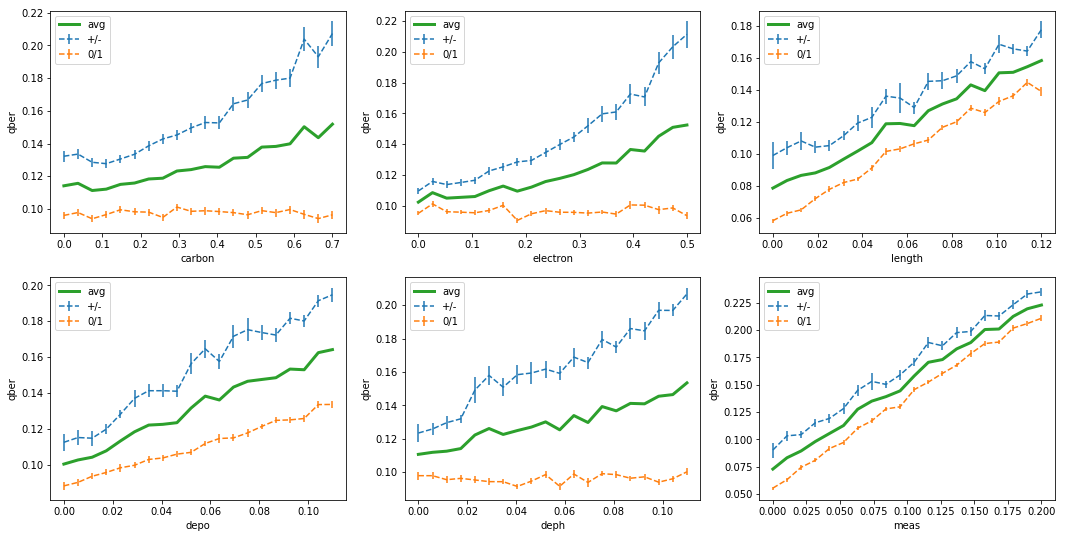

In [79]:
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']
states = ['+/-', '0/1']
noiselist = [0]*6
noiselist_std = [0]*6

for i, noise in enumerate(noises):
    noiselist[i] = np.loadtxt('data/ek91_'+noise)
    noiselist_std[i] = np.loadtxt('data/ek91_'+noise+'_std')

plot_noises(noiselist, noiselist_std, states, noises)